<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import" data-toc-modified-id="Import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import</a></span></li><li><span><a href="#Pre-Processing" data-toc-modified-id="Pre-Processing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Pre-Processing</a></span></li><li><span><a href="#Custom-Dataset" data-toc-modified-id="Custom-Dataset-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Custom Dataset</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Inference" data-toc-modified-id="Inference-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Inference</a></span></li><li><span><a href="#Submission" data-toc-modified-id="Submission-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Submission</a></span></li></ul></div>

## Import

In [1]:
import random
import os

import numpy as np
import pandas as pd

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import torch
import torch.nn as nn
from torch.utils.data import Dataset

from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.utils import from_smiles
from torch_geometric.loader import DataLoader




In [2]:
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

In [3]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)

seed_everything(42) # Seed 고정

## Pre-Processing

In [37]:
train = pd.read_csv('./train.csv').drop(columns=["id"])
test = pd.read_csv('./test.csv').drop(columns=["id"])

In [5]:
# 사용할 column만 추출
# train = train[['SMILES','MLM', 'HLM', 'AlogP', 'Molecular_Weight', 'Num_H_Acceptors', 'Num_H_Donors', 'Molecular_PolarSurfaceArea']]
# test = test[['SMILES', 'AlogP', 'Molecular_Weight', 'Num_H_Acceptors', 'Num_H_Donors', 'Molecular_PolarSurfaceArea']]

In [6]:
imputer = IterativeImputer(estimator=RandomForestRegressor(n_jobs=-1), random_state=42)
imputer.fit_transform(train.drop(columns=['SMILES', 'MLM', 'HLM']))
imputer.transform(test.drop(columns='SMILES'))

array([[  2.641, 361.505,   4.   , ...,   7.   ,   2.635,  92.76 ],
       [  0.585, 370.399,   5.   , ...,   3.   ,   0.585,  68.31 ],
       [  4.276, 347.414,   4.   , ...,   5.   ,   4.29 ,  92.86 ],
       ...,
       [  1.792, 349.383,   3.   , ...,   3.   ,   1.792,  69.72 ],
       [  0.79 , 341.132,   3.   , ...,   2.   ,   0.423,  69.64 ],
       [  2.782, 250.38 ,   2.   , ...,   5.   ,   0.606,  19.62 ]])

## Custom Dataset

In [7]:
class CustomDataset(Dataset):
    def __init__(self, df, target, is_test=False):
        self.df = df
        self.target = target # HLM or MLM
        self.is_test = is_test # train,valid / test
        self.scaler = MinMaxScaler()
        
        if not self.is_test: 
            self.graph = self.smiles2mol(df['SMILES'])
            self.others = self.scaler.fit_transform(df.iloc[:,3:])

        else: # valid or test
            self.graph = self.smiles2mol(df['SMILES'])
            self.others = self.scaler.fit_transform(df.iloc[:,1:])

    def smiles2mol(self, smiles_list):
        graph_list = []
        for smiles in smiles_list:
            graph_data = from_smiles(smiles)

            graph_data.smiles = None
            graph_data.edge_attr = None

            graph_list.append(graph_data)
        return graph_list            
            
    def __getitem__(self, index):
        graph = self.graph[index]
        others = self.others[index]
        if not self.is_test: # test가 아닌 경우(label 존재)
            label = self.df[self.target][index]
            return graph, torch.tensor(others).float(), torch.tensor(label).float().unsqueeze(dim=-1) # feature, label

        else: # test인 경우
            return graph, torch.tensor(others).float() # feature

    def __len__(self):
        return len(self.df)

In [8]:

train_MLM = CustomDataset(df=train, target='MLM', is_test=False)
train_HLM = CustomDataset(df=train, target='HLM', is_test=False)

# input_size1 = 9

input_size1 = train_MLM.graph[1].x.size(1)
input_size2 = train_MLM.others.shape[1]
print(input_size1, input_size2)

9 7


In [9]:
# Hyperparameter
CFG = {'BATCH_SIZE': 512,
       'EPOCHS': 300,
       'INPUT_SIZE1': input_size1,
       'INPUT_SIZE2': input_size2,
       'HIDDEN_SIZE1': 512,
       'HIDDEN_SIZE2': 512,
       'OUTPUT_SIZE': 1,
       'DROPOUT_RATE': 0.9,
       'LEARNING_RATE': 1e-12}

In [10]:
# train,valid split
train_MLM_dataset, valid_MLM_dataset = train_test_split(train_MLM, test_size=0.2, random_state=42)
train_HLM_dataset, valid_HLM_dataset = train_test_split(train_HLM, test_size=0.2, random_state=42)

In [11]:
train_MLM_loader = DataLoader(dataset=train_MLM_dataset,
                              batch_size=CFG['BATCH_SIZE'],
                              shuffle=True)

valid_MLM_loader = DataLoader(dataset=valid_MLM_dataset,
                              batch_size=CFG['BATCH_SIZE'],
                              shuffle=False)


train_HLM_loader = DataLoader(dataset=train_HLM_dataset,
                              batch_size=CFG['BATCH_SIZE'],
                              shuffle=True)

valid_HLM_loader = DataLoader(dataset=valid_HLM_dataset,
                              batch_size=CFG['BATCH_SIZE'],
                              shuffle=False)

## Model

In [12]:
class Net(nn.Module):
    def __init__(self, input_size2, hidden_size2, dropout_rate, output_size):
        super(Net, self).__init__()
        
        # fc 레이어 3개와 출력 레이어
        self.fc1 = nn.Linear(input_size2, hidden_size2) 
        self.fc2 = nn.Linear(hidden_size2, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size2)
        self.fc4 = nn.Linear(hidden_size2, hidden_size2)
        self.fc_out = nn.Linear(hidden_size2, output_size)
        
        # 정규화
        self.ln1 = nn.LayerNorm(hidden_size2)
        self.ln2 = nn.LayerNorm(hidden_size2)
        self.ln3 = nn.LayerNorm(hidden_size2)        
        self.ln4 = nn.LayerNorm(hidden_size2)
        
        # 활성화 함수
        self.activation = nn.ReLU()
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
        
    
    def forward(self, x):
        
        out = self.fc1(x)
        out = self.ln1(out)
        out = self.activation(out)
        out = self.dropout(out)
        
        out = self.fc2(out)
        out = self.ln2(out)
        out = self.activation(out)
        out = self.dropout(out)
        
        out = self.fc3(out)
        out = self.ln3(out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.fc4(out)
        out = self.ln4(out)
        out = self.activation(out)
        out = self.dropout(out)
        
        out = self.fc_out(out)
        return out

In [13]:
# GNN 모델 정의
class GNN(nn.Module):
    def __init__(self, input_size1, hidden_size1, dropout_rate, output_size):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_size1, hidden_size1)
        self.conv2 = GCNConv(hidden_size1, hidden_size1)
        self.conv3 = GCNConv(hidden_size1, hidden_size1)
        self.conv4 = GCNConv(hidden_size1, hidden_size1)
        self.fc_out = nn.Linear(hidden_size1, output_size)
        
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.bn2 = nn.BatchNorm1d(hidden_size1)
        self.bn3 = nn.BatchNorm1d(hidden_size1)
        self.bn4 = nn.BatchNorm1d(hidden_size1)
        
        # 활성화 함수
        self.activation = nn.ReLU()
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
    
     
    def forward(self, x, edge_idx_, batch):
        out, edge_index = x, edge_idx_

        out = self.conv1(out, edge_index)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.dropout(out)
        
        out = self.conv2(out, edge_index)
        out = self.bn2(out)
        out = self.activation(out)
        out = self.dropout(out)
        
        out = self.conv3(out, edge_index)
        out = self.bn3(out)
        out = self.activation(out)
        out = self.dropout(out)
        
        out = self.conv4(out, edge_index)
        out = self.bn4(out)
        out = self.activation(out)
        out = self.dropout(out)
        
        out = global_mean_pool(out, batch) # read-out layer
        
        out = self.fc_out(out)
        return out


In [14]:
class ClassificationModel(nn.Module):
    def __init__(self, input_size1, input_size2, hidden_size1, hidden_size2, drop_rate, output_size):
        super(ClassificationModel, self).__init__()
        self.GNN_extractor = GNN(input_size1, hidden_size1, drop_rate, output_size)
        self.Net_extractor = Net(input_size2, hidden_size2, drop_rate, output_size)
#         self.classifier = nn.Linear(in_features=hidden_size*2, out_features=output_size)
        self.classifier = nn.Linear(in_features=output_size*2, out_features=output_size)

    def forward(self, graph, others, edge_idx_, batch):
        GNN_feature = self.GNN_extractor(graph, edge_idx_, batch)
        Net_feature = self.Net_extractor(others)
        feature = torch.cat([GNN_feature, Net_feature], dim=-1)
        output = self.classifier(feature)
        return output

In [15]:
model_MLM = ClassificationModel(CFG['INPUT_SIZE1'],CFG['INPUT_SIZE2'],CFG['HIDDEN_SIZE1'],CFG['HIDDEN_SIZE2'],CFG['DROPOUT_RATE'],CFG['OUTPUT_SIZE'])
model_HLM = ClassificationModel(CFG['INPUT_SIZE1'],CFG['INPUT_SIZE2'],CFG['HIDDEN_SIZE1'],CFG['HIDDEN_SIZE2'],CFG['DROPOUT_RATE'],CFG['OUTPUT_SIZE'])


In [16]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

In [17]:
# criterion = nn.MSELoss()
optimizer_MLM = torch.optim.Adam(model_MLM.parameters(), lr=CFG['LEARNING_RATE'])
optimizer_HLM = torch.optim.Adam(model_HLM.parameters(), lr=CFG['LEARNING_RATE'])
# optimizer_MLM = torch.optim.SGD(model_MLM.parameters(), lr=CFG['LEARNING_RATE'], momentum=0.9)
# optimizer_HLM = torch.optim.SGD(model_HLM.parameters(), lr=CFG['LEARNING_RATE'], momentum=0.9)
# scheduler_MLM = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_MLM, mode='min', factor=0.5, patience=5, threshold_mode='abs', min_lr=0, eps=1e-8, verbose=True)
# scheduler_HLM = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_HLM, mode='min', factor=0.5, patience=5, threshold_mode='abs', min_lr=0, eps=1e-8, verbose=True)
scheduler_MLM = CosineAnnealingWarmUpRestarts(optimizer_MLM, T_0=60, T_mult=1, eta_max=0.1,  T_up=6, gamma=0.5)
scheduler_HLM = CosineAnnealingWarmUpRestarts(optimizer_HLM, T_0=60, T_mult=1, eta_max=0.1,  T_up=6, gamma=0.5)
#주기, 주기변화율, 최대lr, 초기활성ep, 진폭변화율

## Training

In [18]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_hat, y):
        loss = torch.sqrt(self.mse(y_hat,y))
        return loss

In [19]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.train()
    model.to(device)

    criterion = RMSELoss().to(device)
    
    
    for epoch in range(CFG['EPOCHS']):
        running_loss = 0
        for inputs, others, targets in train_loader:
            optimizer.zero_grad()
            inputs_ = inputs.x.type(torch.float32).to(device)
            edge_idx_ = inputs.edge_index.to(device)
            others = others.to(device)
            targets = targets.to(device)
            batch = inputs.batch.to(device)

            output = model(inputs_, others, edge_idx_, batch)

            
            loss = criterion(output, targets)

            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            

            
        if epoch % 10 == 0:
            
            val_loss = validation(model, criterion, val_loader, device)
            
            print(f'Epoch: {epoch}, Train Loss: {running_loss/len(train_loader)}, Valid Loss: {val_loss/len(valid_HLM_loader)}')
            
            model.train()
            
        if scheduler is not None:
            scheduler.step(val_loss)
#             if scheduler.num_bad_epochs > scheduler.patience:
#                 print(f'Early stopping at epoch {epoch}...')
#                 break
    return model

In [20]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for inputs, others, targets in val_loader:
            inputs_ = inputs.x.type(torch.float32).to(device)
            edge_idx_ = inputs.edge_index.to(device)
            others = others.to(device)
            targets = targets.to(device)
            batch = inputs.batch.to(device)
            
            output = model(inputs_, others, edge_idx_, batch)
            loss = criterion(output, targets)
            val_loss += loss.item()
            
    
    return val_loss

In [21]:
print("Training Start: MLM")
# model_MLM = train(train_MLM_loader, valid_MLM_loader, model_MLM, criterion, optimizer_MLM, epochs=CFG['EPOCHS'])
model_MLM = train(model_MLM, optimizer_MLM, train_MLM_loader, valid_MLM_loader, scheduler_MLM, device)
print("Training Start: HLM")
# model_HLM = train(train_HLM_loader, valid_HLM_loader, model_HLM, criterion, optimizer_HLM, epochs=CFG['EPOCHS'])
model_HLM = train(model_HLM, optimizer_HLM, train_HLM_loader, valid_HLM_loader, scheduler_HLM, device)

Training Start: MLM


/opt/homebrew/Caskroom/miniforge/base/envs/dl/lib/python3.9/site-packages/torch_geometric/nn/pool/glob.py:62: UserWarning: MPS: no support for int64 min/max ops, casting it to int32 (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343673238/work/aten/src/ATen/native/mps/operations/ReduceOps.mm:1271.)
  size = int(batch.max().item() + 1) if size is None else size


Epoch: 0, Train Loss: 51.62518310546875, Valid Loss: 53.26648139953613
Epoch: 10, Train Loss: 34.22912089029948, Valid Loss: 38.31791687011719
Epoch: 20, Train Loss: 34.71701304117838, Valid Loss: 35.34318161010742
Epoch: 30, Train Loss: 33.59823226928711, Valid Loss: 36.71169853210449
Epoch: 40, Train Loss: 33.89349047342936, Valid Loss: 35.64033889770508
Epoch: 50, Train Loss: 33.53325208028158, Valid Loss: 36.46069526672363
Epoch: 60, Train Loss: 33.50884246826172, Valid Loss: 39.76544952392578
Epoch: 70, Train Loss: 33.56611760457357, Valid Loss: 36.759124755859375
Epoch: 80, Train Loss: 33.09699312845866, Valid Loss: 35.68182945251465
Epoch: 90, Train Loss: 33.37413787841797, Valid Loss: 35.843393325805664
Epoch: 100, Train Loss: 33.29993120829264, Valid Loss: 38.28512001037598
Epoch: 110, Train Loss: 33.017739613850914, Valid Loss: 38.321083068847656
Epoch: 120, Train Loss: 33.23372332255045, Valid Loss: 40.96507263183594
Epoch: 130, Train Loss: 33.09641965230306, Valid Loss: 37.

## Inference

In [22]:
test_MLM = CustomDataset(df=test, target=None, is_test=True)
test_HLM = CustomDataset(df=test, target=None, is_test=True)

test_MLM_loader = DataLoader(dataset=test_MLM,
                             batch_size=CFG['BATCH_SIZE'],
                             shuffle=False)

test_HLM_loader = DataLoader(dataset=test_HLM,
                             batch_size=CFG['BATCH_SIZE'],
                             shuffle=False)

In [23]:
def inference(test_loader, model):
    model.eval()
    preds = []
    
    with torch.no_grad():
        for inputs, others in test_loader:
            inputs_ = inputs.x.type(torch.float32).to(device)
            edge_idx_ = inputs.edge_index.to(device)
            others = others.to(device)
            batch = inputs.batch.to(device)
            
            output = model(inputs_, others, edge_idx_, batch)
            preds.extend(output.cpu().numpy().flatten().tolist())
    
    return preds

In [24]:
predictions_MLM = inference(test_MLM_loader, model_MLM)
predictions_HLM = inference(test_HLM_loader, model_HLM)

## Submission

In [25]:
submission = pd.read_csv('./sample_submission.csv')
submission

,id,MLM,HLM
0,TEST_000,0,0
1,TEST_001,0,0
2,TEST_002,0,0
3,TEST_003,0,0
4,TEST_004,0,0
...,...,...,...
478,TEST_478,0,0
479,TEST_479,0,0
480,TEST_480,0,0
481,TEST_481,0,0


In [26]:
submission['MLM'] = predictions_MLM
submission['HLM'] = predictions_HLM
submission

,id,MLM,HLM
0,TEST_000,21.748301,31.806074
1,TEST_001,36.054173,42.801453
2,TEST_002,29.101400,37.973015
3,TEST_003,27.596043,38.397438
4,TEST_004,30.826948,40.651085
...,...,...,...
478,TEST_478,15.455660,23.015387
479,TEST_479,47.134033,55.452629
480,TEST_480,31.605787,35.862236
481,TEST_481,51.585655,51.985855


array([[<Axes: title={'center': 'MLM'}>, <Axes: title={'center': 'HLM'}>]],
      dtype=object)

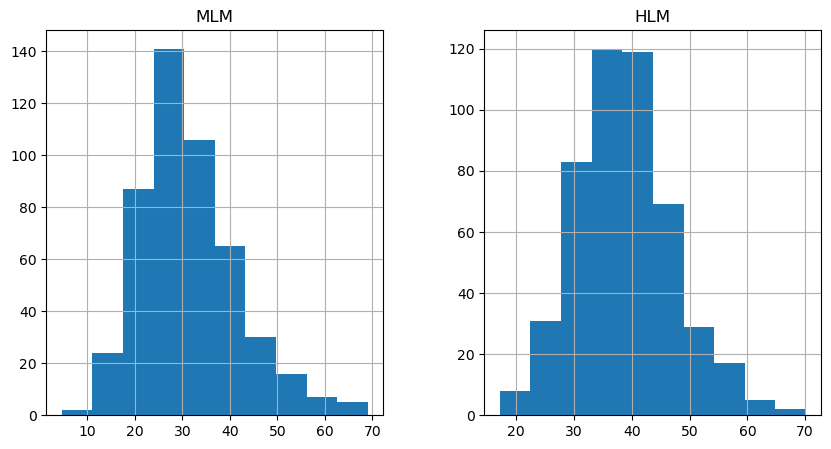

In [36]:
submission.hist(figsize=[10, 5])

In [27]:
submission.to_csv('baseline_submission.csv', index=False)